In [1]:
import os
import time
import numpy as np
from pyhdf.SD import SD, SDC
import h5py
import xarray as xr
import pandas as pd

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

## This code concat the TRMM TMPA CONUS for each year

In [1]:
# YY = 2008 
# YY = 2009
# YY = 2010
# YY = 2011 
# YY = 2012
YY = 2013 # Missing times
# YY = 2014 # Blank list
# YY = 2015 # Blank list
# YY = 2016 # Blank list

In [25]:
data_base = os.path.join('..','data','tmpa_raw_data')

In [26]:
TRMM_files = sorted([f for f in os.listdir(os.path.join(data_base)) if f.endswith('.HDF')])
TRMM_len = len(TRMM_files)
print(f'Number of files: {TRMM_len}')
print(f'The first time : {TRMM_files[0]}')
print(f'The last time  : {TRMM_files[-1]}')

Number of files: 17428
The first time : 3B42.20080101.03.7A.HDF
The last time  : 3B42.20170101.00.7.HDF


In [27]:
year_list = []
time_vector = []
for nn in range(TRMM_len):
    date_ref = pd.to_datetime(TRMM_files[nn].split('.')[1]+TRMM_files[nn].split('.')[2], format='%Y%m%d%H')
    if date_ref.year == YY:
        year_list.append(TRMM_files[nn])
        time_vector.append(TRMM_files[nn].split('.')[1]+TRMM_files[nn].split('.')[2])

if len(year_list) == 0 or len(time_vector) == 0:
    raise SystemExit(f"ERROR: DON'T CONTINUE - {YY} has empty list!")

else:
    time_vector = pd.to_datetime(time_vector, format='%Y%m%d%H')
    print(f'First time: {time_vector[0]}')
    print(f'End time  : {time_vector[-1]}')
    print(f'Times     : {len(year_list)}')

    if len(year_list) < 2920:
        print()
        raise SystemExit("ERROR: DON'T CONTINUE - {YY} has missing times!")

First time: 2013-01-01 00:00:00
End time  : 2013-12-31 21:00:00
Times     : 2809



SystemExit: ERROR: DON'T CONTINUE - {YY} has missing times!

In [17]:
# # boundaries of the selected bounding box
box_name = 'Conus'
solat = 22    # south bound
nolat = 50    # north
welon = -130  # west
ealon = - 60   # east

lat    = np.arange(-49.875, 49.876, 0.25) # South to North
lon   = np.arange(-179.875, 179.876, 0.25) # West to East
nlon        = np.size(lon)
nlat        = np.size(lat)

# mask arrays for selected  bounding box
bblat = np.logical_and(lat >= solat, lat <= nolat)
bblon = np.logical_and(lon >= welon, lon <= ealon)

boxlat = lat[bblat]
boxlon = lon[bblon]

boxx = np.arange(nlon, dtype=int)[bblon]
boxy = np.arange(nlat, dtype=int)[bblat]

nblat = np.size(boxy)
nblon = np.size(boxx)

In [18]:
PRE = np.zeros([len(boxlon), len(boxlat), len(year_list)])
count = 0

for nn in range(len(year_list)):#len(year_list)

    try:
        filename = os.path.join(data_base,year_list[nn])
        hdf = SD(filename, SDC.READ)
        prcpmat_rates = hdf.select('precipitation')[int(boxx[0]):int(boxx[-1]+1), int(boxy[0]):int(boxy[-1]+1)]
        PRE[:,:,nn] = prcpmat_rates*3 # accumulations

    except:
        PRE[:,:,nn] = np.nan
        count = count + 1

PRE[PRE<0] = np.nan

percent = 100 + (count - len(year_list))/len(year_list) * 100
print(f'Percent of MISSIG data in {YY} is {np.round(percent, 3)}%')

Percent of MISSIG data in 2012 is 0.0%


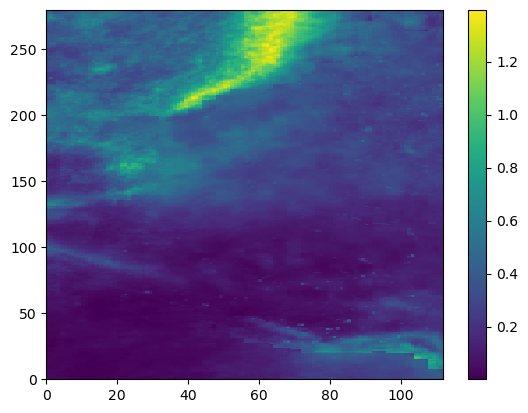

In [19]:
plt.pcolor(np.nanmean(PRE,axis=2))
plt.colorbar()

In [20]:
PRE_xr = xr.Dataset(data_vars={"PRE": (("lon","lat", "time"), PRE)},
                    coords={'time': time_vector, 'lat': boxlat, 'lon': boxlon},
                    attrs=dict(description=f"TRMM TMPA 3 hour {YY} data for CONUS region"))

PRE_xr.PRE.attrs["units"] = "mm/hr"
PRE_xr.PRE.attrs["long_name"] = "3 hour precipitation rate"
PRE_xr.PRE.attrs["origname"] = "precipitation"

PRE_xr.lat.attrs["units"] = "degrees_north"
PRE_xr.lat.attrs["long_name"] = "Latitude"

PRE_xr.lon.attrs["units"] = "degrees_east"
PRE_xr.lon.attrs["long_name"] = "Longitude"

In [21]:
PRE_xr

<xarray.Dataset> Size: 735MB
Dimensions:  (lon: 280, lat: 112, time: 2928)
Coordinates:
  * time     (time) datetime64[ns] 23kB 2012-01-01 ... 2012-12-31T21:00:00
  * lat      (lat) float64 896B 22.12 22.38 22.62 22.88 ... 49.38 49.62 49.88
  * lon      (lon) float64 2kB -129.9 -129.6 -129.4 ... -60.62 -60.38 -60.12
Data variables:
    PRE      (lon, lat, time) float64 735MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  TRMM TMPA 3 hour 2012 data for CONUS region

In [22]:
yy_s = pd.to_datetime(time_vector[0]).year
mm_s = str(pd.to_datetime(time_vector[0]).month).zfill(2)
dd_s = str(pd.to_datetime(time_vector[0]).day).zfill(2)

yy_e = pd.to_datetime(time_vector[-1]).year
mm_e = str(pd.to_datetime(time_vector[-1]).month).zfill(2)
dd_e = str(pd.to_datetime(time_vector[-1]).day).zfill(2)

print(f'Start time: {dd_s}/{mm_s}/{yy_s}')
print(f'End time: {dd_e}/{mm_e}/{yy_e}')

Start time: 01/01/2012
End time: 31/12/2012


In [23]:
PRE_out = os.path.join('..','data','tmpa_year',f'data_tmpa_3h_{YY}.nc')
print(f'Export PRE data to {PRE_out}')
PRE_xr.to_netcdf(PRE_out)

Export PRE data to ../data/tmpa_year/data_tmpa_3h_2012.nc
